In [1]:
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
gen = load_model('emnist_condit_models/10epochs/emnist_generator.h5')

In [3]:
def condit_generate_latent_points(latent_dim, n_samples, n_classes=62):
    # generate points in the latent space
    x_input = np.random.randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = np.random.randint(0, n_classes, n_samples)
    return [z_input, labels]

In [4]:
def translate(string,labelDict):
    out=[]
    for i in string:
        out.append(labelDict[i])
    return np.asarray(out)

def toImage(string,generatorModel,labelDict):
    out=[]
    for i in string.split():
        tempWord=np.array([])
        labels = translate(i,labelDict)
        latent_points, _ = condit_generate_latent_points(latent_dim=100, n_samples=len(i), n_classes=62)
        X = generatorModel.predict([latent_points,labels])
        # scale from [-1,1] to [0,1]
        X = (X + 1) / 2.0
        for j in range(X.shape[0]):
            if tempWord.size==0:
                tempWord = X[j,:,:,0].T
            else:
                tempWord = np.hstack((tempWord,X[j,:,:,0].T))
        if not out:
            out = [tempWord]
        else:
            out.append(tempWord) #god these data types are getting hella dumb
    return out

def joinImages(imArray):
    images = []
    for i in imArray:
        inImage  = np.round(i*255).astype(np.uint8)
        im = Image.fromarray(inImage)
        images.append(im)
        images.append(Image.fromarray(np.zeros((28,28))))
    images.pop() #get rid of last space- not needed

    width = sum(i.size[0] for i in images)
    #joined_im = Image.new('RGB', (width, 28))
    joined_im = Image.new('L', (width, 28))

    x_offset = 0
    for im in images:
        joined_im.paste(im, (x_offset,0))
        x_offset += im.size[0]
    return joined_im

In [5]:
labelMap ={'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9,
 'A': 10,
 'B': 11,
 'C': 12,
 'D': 13,
 'E': 14,
 'F': 15,
 'G': 16,
 'H': 17,
 'I': 18,
 'J': 19,
 'K': 20,
 'L': 21,
 'M': 22,
 'N': 23,
 'O': 24,
 'P': 25,
 'Q': 26,
 'R': 27,
 'S': 28,
 'T': 29,
 'U': 30,
 'V': 31,
 'W': 32,
 'X': 33,
 'Y': 34,
 'Z': 35,
 'a': 36,
 'b': 37,
 'c': 38,
 'd': 39,
 'e': 40,
 'f': 41,
 'g': 42,
 'h': 43,
 'i': 44,
 'j': 45,
 'k': 46,
 'l': 47,
 'm': 48,
 'n': 49,
 'o': 50,
 'p': 51,
 'q': 52,
 'r': 53,
 's': 54,
 't': 55,
 'u': 56,
 'v': 57,
 'w': 58,
 'x': 59,
 'y': 60,
 'z': 61}

In [7]:
def toStackedImage(string,generator,labelDict):
    words = []
    #get generated arrays per word
    for i in string.split():
        word = np.array([])
        labels = translate(i,labelDict)
        latent_points, _ = condit_generate_latent_points(latent_dim=100, n_samples=len(i), n_classes=62)
        X = generator.predict([latent_points,labels])
        # scale from [-1,1] to [0,1]
        X = (X + 1) / 2.0
        for j in range(X.shape[0]):
            if word.size == 0:
                word = np.round((X[j,:,:,0].T*255).astype('uint8'))
            else:
                word = np.hstack((word,np.round((X[j,:,:,0].T*255).astype('uint8'))))
        words.append(word)
    #pad all except last word with a space
    for i in range(len(words)-1):
        words[i] = np.hstack((words[i],np.zeros((28,28)).astype('uint8')))
    
    lines=[words[0]]
    for i in words[1:]:
        if (lines[-1].shape[1]+i.shape[1])<=1008:
            lines[-1] = np.hstack((lines[-1],i))
        else:
            lines.append(i)
    #pad last line:
    for i in range(len(lines)):
        lines[i]=np.hstack((lines[i],np.zeros((28,1008-lines[i].shape[1])).astype('uint8')))
    
    return Image.fromarray(np.vstack((lines)))


def translate(string,labelDict):
    out=[]
    for i in string:
        out.append(labelDict[i])
    return np.asarray(out)

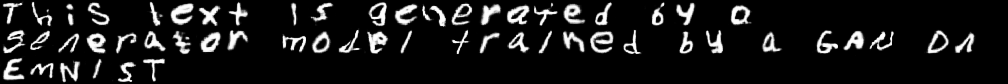

In [195]:
text = 'This text is generated by a generator model trained by a GAN on EMNIST'
text_image = toStackedImage(text,gen,labelMap)
text_image

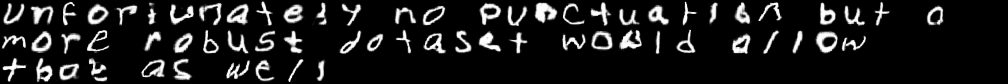

In [198]:
text2 = ' Unfortunately no punctuation but a more robust dataset would allow that as well'
text2_image= toStackedImage(text2,gen,labelMap)
text2_image

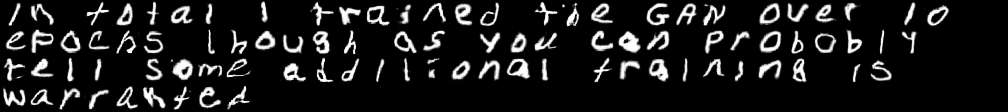

In [201]:
text3 = 'In total I trained the GAN over 10 epochs though as you can probably tell some additional training is warranted'
text3_image= toStackedImage(text3,gen,labelMap)
text3_image

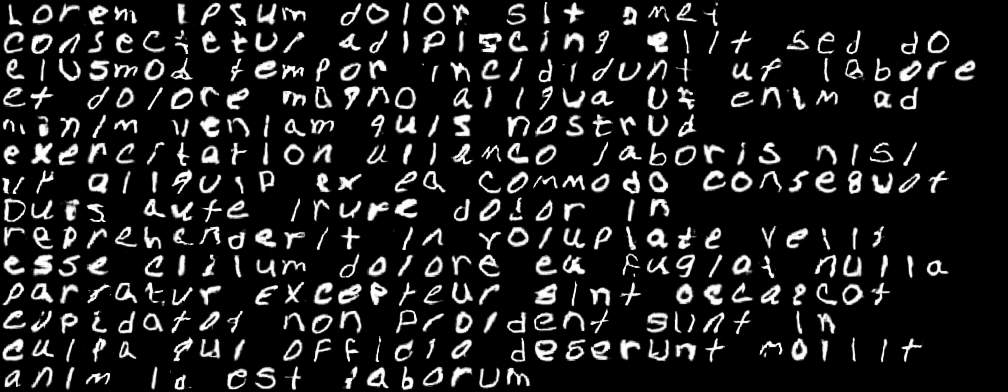

In [14]:
import string
lorem = 'Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.'
for i in string.punctuation:
    lorem=lorem.replace(i,'')
lorem_image = toStackedImage(lorem,gen,labelMap)
lorem_image

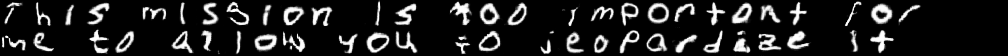

In [8]:
text = 'This mission is too important for me to allow you to jeopardize it'
out = toStackedImage(text,gen,labelMap)
out